# Predicting Insurance Cross Sell Opportunities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Importing the dataset

In [2]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv')
insurance_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
insurance_df.describe().round(2)


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00
mean,190555.00,38.82,1.00,26.39,0.46,30564.39,112.03,154.35,0.12
std,110016.84,15.51,0.05,13.23,0.50,17213.16,54.20,83.67,0.33
min,1.00,20.00,0.00,0.00,0.00,2630.00,1.00,10.00,0.00
25%,95278.00,25.00,1.00,15.00,0.00,24405.00,29.00,82.00,0.00
50%,190555.00,36.00,1.00,28.00,0.00,31669.00,133.00,154.00,0.00
75%,285832.00,49.00,1.00,35.00,1.00,39400.00,152.00,227.00,0.00
max,381109.00,85.00,1.00,52.00,1.00,540165.00,163.00,299.00,1.00


In [4]:
insurance_df.count()

id                      381109
Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 12 features and 381109 observations. The dataset has 8 categorical features and 4 numerical features which are  "ID", "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. 

In [5]:
insurance_df_categorical = insurance_df.drop(["id","Annual_Premium", "Age", "Vintage"],  axis=1).copy()
for column in insurance_df_categorical.columns:
    print(insurance_df_categorical[column].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

Moreover the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced (for example, 'Vehicle_Age' has 164786 observations for '< 1 Year' and 200316 observations for '> 2 Years'). This is an important factor to consider while building the model.<br>
It is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and just 41 of them are interested in the vehicle insurance. This is a very small number of observations.

In [6]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())

#potrebbe trattarsi di una bicicletta o di un monopattino elettrico ad esempio


Response
0    771
1     41
Name: count, dtype: int64


# Data Preprocessing

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, classification_report

def encode_set(dataset, X=np.array([]), label_encoder=LabelEncoder(), one_hot_encoder=None):
    for column in dataset.columns:
        X_tmp = label_encoder.fit_transform(dataset[column])
        X_tmp = X_tmp.reshape(X_tmp.shape[0],1)
        if(one_hot_encoder is not None):
            X_tmp = one_hot_encoder.fit_transform(X_tmp[:,0].reshape(-1,1)).toarray()
        if X.shape[0] == 0:
            X = X_tmp
        else:
            X = np.hstack((X_tmp, X))
        print(f"Categorical feature: {column}, Number of categories: {X_tmp[1,:].shape[0]}")
    return X


def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_))


def random_split_train_test_set(X, Y, test_size=0.20, random_state=42):
    m = X.shape[0]
    m_train = int(m * (1-test_size))
    m_test = m - m_train

    
    random_indices = np.random.permutation(m)
    X_rand = X[random_indices]
    Y_rand = Y[random_indices]

    X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state=random_state)
    return X_training, X_test, Y_training, Y_test

def plot_confusion_matrix(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(data=confusion_matrix, annot=True, fmt='g')
    plt.title(title)
    ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
    ax.yaxis.set_ticklabels(['No', 'Yes'])
    plt.show()

In [8]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

X = insurance_df.drop(["id","Response","Gender", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Policy_Sales_Channel"], axis=1).copy()
print(X.shape)
insurance_df_categorical = insurance_df_categorical.drop("Response", axis=1).copy()
X = encode_set(insurance_df_categorical, X, label_encoder, one_hot_encoder)


(381109, 3)
Categorical feature: Gender, Number of categories: 2
Categorical feature: Driving_License, Number of categories: 2


Categorical feature: Region_Code, Number of categories: 53
Categorical feature: Previously_Insured, Number of categories: 2
Categorical feature: Vehicle_Age, Number of categories: 3
Categorical feature: Vehicle_Damage, Number of categories: 2
Categorical feature: Policy_Sales_Channel, Number of categories: 155


In [9]:
Y = insurance_df["Response"].copy()
Y = label_encoder.fit_transform(Y)
Y

array([1, 0, 1, ..., 0, 0, 0])

In [10]:
RANDOM_SEED = 42

X_training, X_test, Y_training, Y_test = random_split_train_test_set(X, Y, test_size=0.20, random_state = RANDOM_SEED) 

m_training = X_training.shape[0]
m_test = X_test.shape[0]

#let's see what the fraction of ones in the entire dataset is
print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_training), 3))
print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_training+m_test), 3))


Fraction of ones in the train set:  0.123
Fraction of ones in the test set:  0.122
Fraction of ones in the entire dataset:  0.123


In [11]:
std_scaler = StandardScaler()
X_training = std_scaler.fit_transform(X_training)

## Model 1: LogisticRegression with L1

In [12]:
from sklearn.linear_model import LogisticRegression
#log_reg = LogisticRegression(penalty='l1', C=10000, solver='saga', class_weight='balanced')
log_reg = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True)


Accuracy: 0.695
Log-Loss: 0.472
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267480
           1       0.28      0.94      0.43     37407

    accuracy                           0.70    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.70      0.75    304887



In [13]:
evaluate_model(log_reg, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

Accuracy: 0.693
Log-Loss: 0.475
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66919
           1       0.28      0.93      0.43      9303

    accuracy                           0.69     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.69      0.75     76222



In [14]:
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report
y_pred_proba_training = log_reg.predict_proba(X_training)
y_pred_train = log_reg.predict(X_training)
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = log_reg.predict(X_test)

confusion_matrix_train = confusion_matrix(Y_training, y_pred_train)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

print("Confusion matrix for training set:")
print(confusion_matrix_train)
print("Confusion matrix for test set:")
print(confusion_matrix_test)



Confusion matrix for training set:
[[176844  90636]
 [  2344  35063]]
Confusion matrix for test set:
[[  583 66336]
 [   31  9272]]


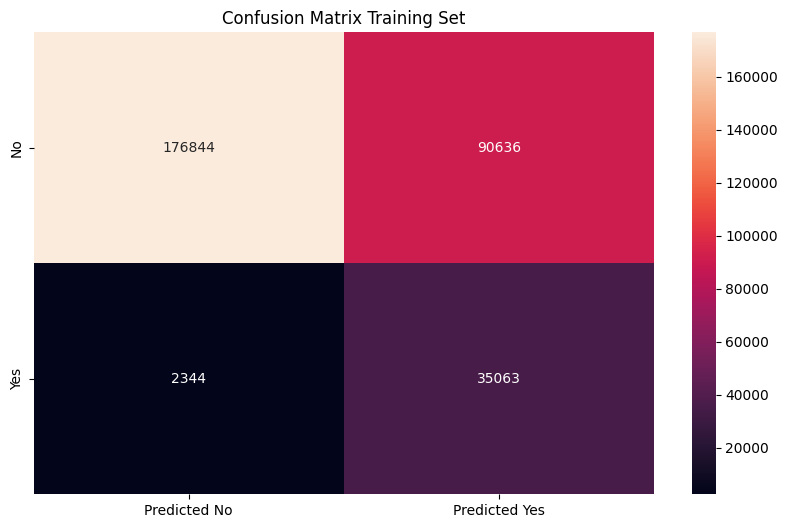

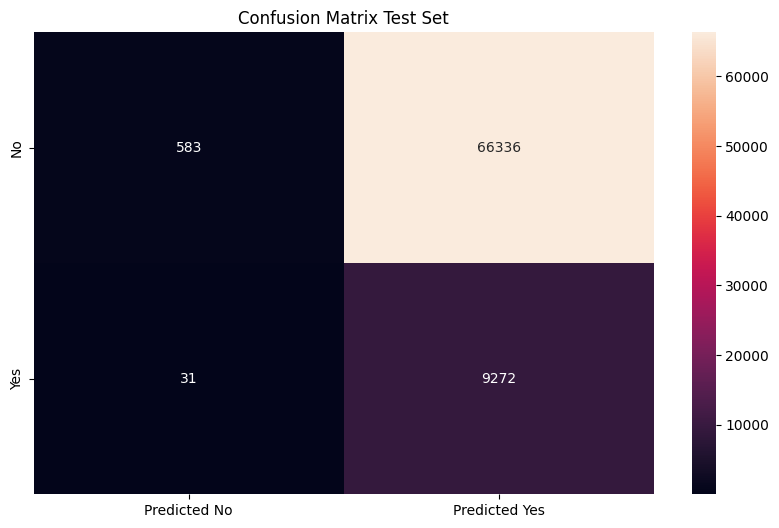

In [15]:
plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")


## Model 2: LogisticRegression with Cross Validation and polynomial features

In [16]:
from sklearn.linear_model import LogisticRegressionCV


In [17]:
def logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="lbfgs" ,class_weight='balanced'):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=cv, penalty=penalty, class_weight=class_weight, solver=solver)
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in {}-fold Cross-Validation: {}".format(cv, log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),10)
    print("Accuracies obtained for the different values of C with {}-fold Cross-Validation: {}".format(cv, CV_accuracies ))

    print("Best value C according to {}-fold Cross-Validation: {}".format(cv, log_reg_cv.C_[0] ))

    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("{}-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format(cv, regL2_best_CV_accuracy))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty=penalty, class_weight=class_weight, solver=solver)


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)


    evaluate_model(regL2_full, (X_training, Y_training), print_report=True)
    return regL2_full


Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.69240405 0.69403745 0.69472951 0.6947951  0.69482134 0.69481478
 0.69482134 0.69481478 0.69481806 0.6948115 ]
Best value C according to 10-fold Cross-Validation: 0.3593813663804626
10-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7003837449571977
Accuracy: 0.695
Log-Loss: 0.472
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267480
           1       0.28      0.94      0.43     37407

    accuracy                           0.70    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.70      0.75    304887

Accuracy: 0.694
Log-Loss: 0.476
Test Report:
      

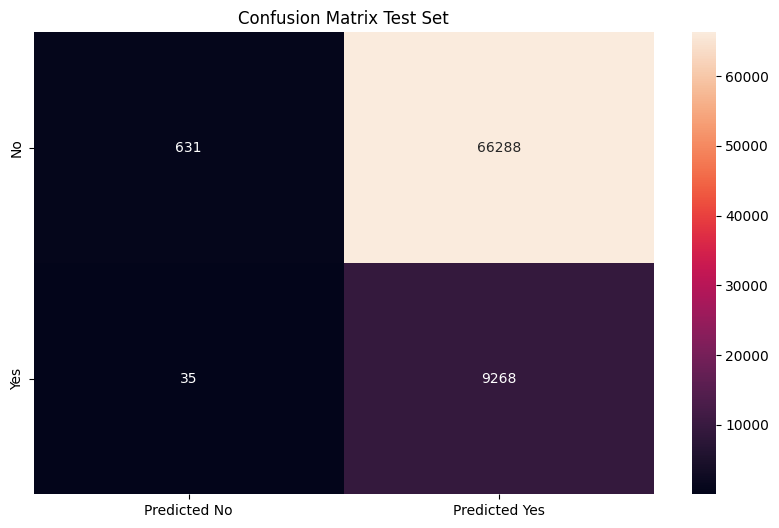

In [18]:
regL2_full = logistic_regression_CV(X_training, Y_training)

evaluate_model(regL2_full, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

y_pred_proba_test = regL2_full.predict_proba(X_test)
y_pred_test = regL2_full.predict(X_test)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

## Rimuovo samples per ribalanciare il dataset


In [303]:
df = pd.read_csv('data/insurance_cross_sell.csv')
df = df.drop(['id'], axis=1)

df.describe().round(2)



,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00
mean,38.82,1.00,26.39,0.46,30564.39,112.03,154.35,0.12
std,15.51,0.05,13.23,0.50,17213.16,54.20,83.67,0.33
min,20.00,0.00,0.00,0.00,2630.00,1.00,10.00,0.00
25%,25.00,1.00,15.00,0.00,24405.00,29.00,82.00,0.00
50%,36.00,1.00,28.00,0.00,31669.00,133.00,154.00,0.00
75%,49.00,1.00,35.00,1.00,39400.00,152.00,227.00,0.00
max,85.00,1.00,52.00,1.00,540165.00,163.00,299.00,1.00


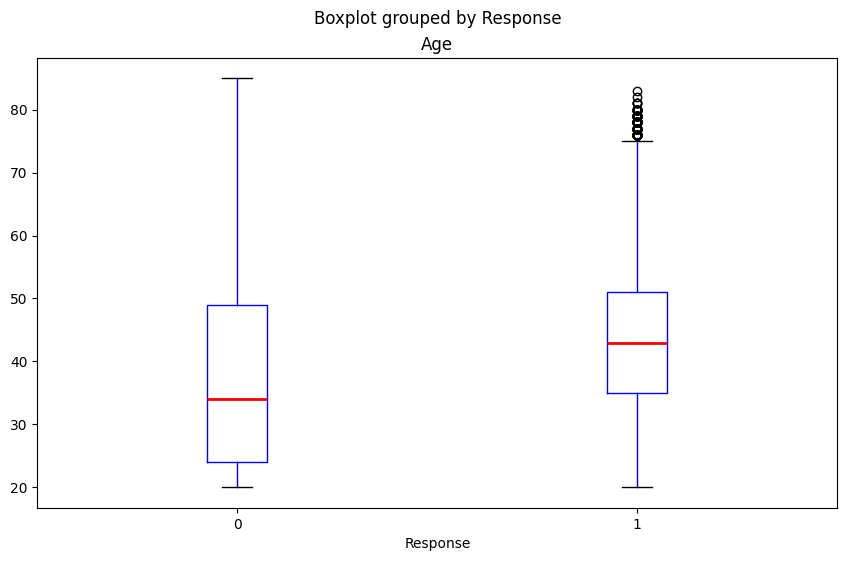

In [304]:
boxplt = df.boxplot(column='Age', by='Response', figsize=(10, 6), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) ) # medianprops=dict(color="red", linewidth=2), 


In [305]:
#df["Age"].value_counts().where(lambda x : x < 4000).dropna()
df.loc[df['Age']<=25, 'Age_Class'] = 'cl1'
df.loc[df['Age'].between(25,34), 'Age_Class'] = 'cl2'
df.loc[df['Age'].between(35,44), 'Age_Class'] = 'cl3'
df.loc[df['Age'].between(45,54), 'Age_Class'] = 'cl4'
df.loc[df['Age']>=55, 'Age_Class'] = 'cl5'



In [306]:
df = df.drop(["Age"], axis=1)
df.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Class
0,Male,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,cl3
1,Male,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,cl5
2,Male,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,cl4
3,Male,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,cl1
4,Female,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,cl2


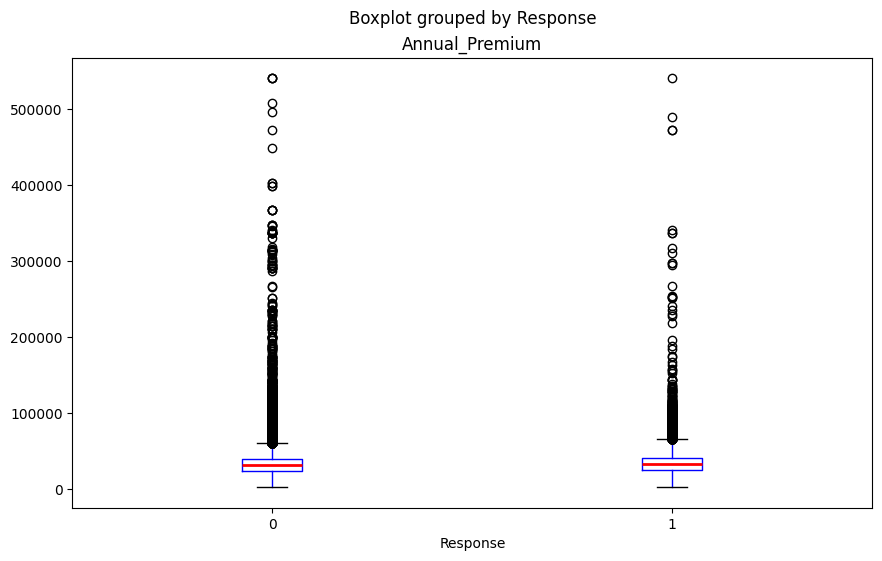

In [307]:
boxplt = df.boxplot(column='Annual_Premium', by='Response', figsize=(10, 6), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) ) # medianprops=dict(color="red", linewidth=2), 


In [308]:
#df_annual_premium = df[["Annual_Premium"]].copy()
#df_annual_premium.loc[df["Annual_Premium"].value_counts().where(lambda x : x < 200).dropna(), 'Annual_Premium_Class'] = 'pr1'
#df_annual_premium.loc[df["Annual_Premium"].value_counts().where(lambda x : x > 200).dropna(), 'Annual_Premium_Class'] = 'pr2'

print(df["Annual_Premium"].where(df["Response"] == 0).dropna().shape)
print(df["Annual_Premium"].where(df["Response"] == 1).dropna().shape)


(334399,)
(46710,)


In [309]:
#df = df[df["Annual_Premium"]<=75000]
df.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Class
0,Male,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,cl3
1,Male,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,cl5
2,Male,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,cl4
3,Male,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,cl1
4,Female,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,cl2


In [310]:
df["Policy_Sales_Channel"].value_counts().where(lambda x : x > 500).dropna()

Policy_Sales_Channel
152.0    134784.0
26.0      79700.0
124.0     73995.0
160.0     21779.0
156.0     10661.0
122.0      9930.0
157.0      6684.0
154.0      5993.0
151.0      3885.0
163.0      2893.0
13.0       1865.0
25.0       1848.0
7.0        1598.0
8.0        1515.0
30.0       1410.0
55.0       1264.0
155.0      1234.0
11.0       1203.0
1.0        1074.0
52.0       1055.0
125.0      1026.0
15.0        888.0
29.0        843.0
12.0        783.0
120.0       769.0
24.0        750.0
31.0        631.0
14.0        622.0
153.0       607.0
61.0        579.0
3.0         523.0
16.0        523.0
60.0        517.0
4.0         509.0
Name: count, dtype: float64

In [311]:
for column in df.columns:
    print(df[column].value_counts().where(lambda x : x > 500).dropna())


Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415.0
8.0      33877.0
46.0     19749.0
41.0     18263.0
15.0     13308.0
30.0     12191.0
29.0     11065.0
50.0     10243.0
3.0       9251.0
11.0      9232.0
36.0      8797.0
33.0      7654.0
47.0      7436.0
35.0      6942.0
6.0       6280.0
45.0      5605.0
37.0      5501.0
18.0      5153.0
48.0      4681.0
14.0      4678.0
39.0      4644.0
10.0      4374.0
21.0      4266.0
2.0       4038.0
13.0      4036.0
7.0       3279.0
12.0      3198.0
9.0       3101.0
27.0      2823.0
32.0      2787.0
43.0      2639.0
17.0      2617.0
26.0      2587.0
25.0      2503.0
24.0      2415.0
38.0      2026.0
0.0       2021.0
16.0      2007.0
31.0      1960.0
23.0      1960.0
20.0      1935.0
49.0      1832.0
4.0       1801.0
34.0      1664.0
19.0      1535.0
22.0      1309.0
40.0      1295.0
5.0       1279.0
1.0       1008.0
44.0       808.0
42.0 

<Axes: >

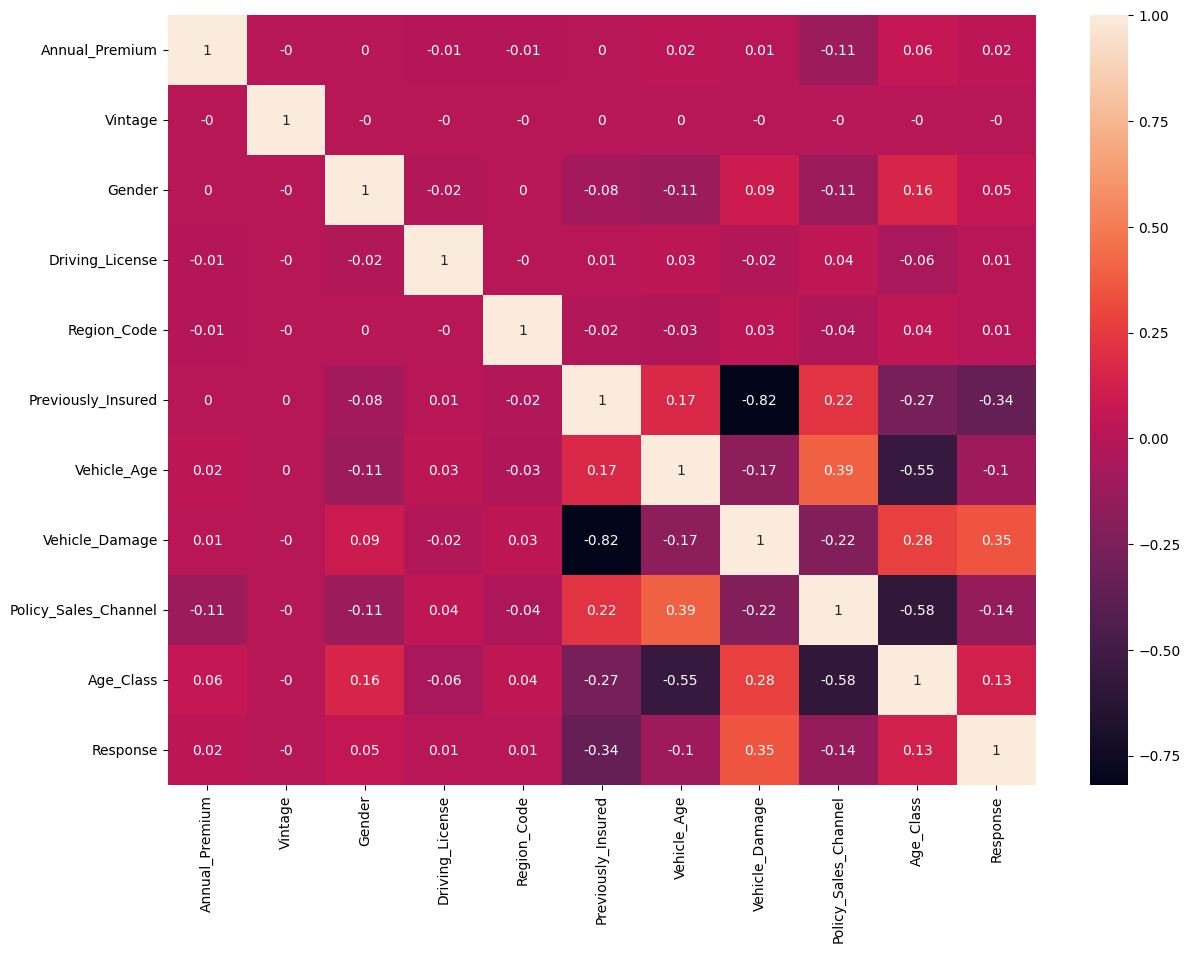

In [312]:
df_categorical = df.drop(["Annual_Premium", "Vintage", "Response"],  axis=1).copy()

for column in df_categorical.columns:
    df_categorical[column] = label_encoder.fit_transform(df_categorical[column])

df_numerical = df[["Annual_Premium", "Vintage"]].copy()

df_to_handle = pd.concat([df_numerical, df_categorical], axis=1)
df_to_handle = pd.DataFrame(std_scaler.fit_transform(df_to_handle), columns=df_to_handle.columns)
df_to_handle = pd.concat([df_to_handle, df["Response"]], axis=1)

#df_to_handle = df_to_handle.groupby('Policy_Sales_Channel').filter(lambda x: len(x)> 10000)

plt.figure(figsize=(14, 10))
corr_matrix = df_to_handle.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [313]:
#Remove highly correlated features
#df_to_handle = df.drop(["Vehicle_Age", "Vehicle_Damage"], axis=1)
#df_to_handle = df.drop(["Vehicle_Damage"], axis=1)


In [314]:
#Remove features with low correlation with the target
#df_to_handle = df_to_handle.drop(["Region_Code", "Annual_Premium"], axis=1)
df_to_handle = df_to_handle.drop(["Region_Code", "Vintage", "Driving_License"], axis=1)


In [315]:
#Remove outliers
#df_to_handle = df_to_handle[df_to_handle["Age"] < 70]
df_to_handle = df_to_handle.groupby('Policy_Sales_Channel').filter(lambda x: len(x)> 1000)
df

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Class
0,Male,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,cl3
1,Male,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,cl5
2,Male,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,cl4
3,Male,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,cl1
4,Female,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,cl2
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0,cl5
381105,Male,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0,cl2
381106,Male,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0,cl1
381107,Female,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0,cl5


In [316]:
#Balance the dataset
#df_to_handle = df_to_handle.groupby('Response').apply(lambda x: x.sample(df_to_handle.Response.value_counts().min(), random_state=RANDOM_SEED)).reset_index(drop=True)
#df_to_handle = df_to_handle.groupby('Policy_Sales_Channel').filter(lambda x: len(x)> 100)

idx = df_to_handle[df_to_handle['Response'] == 0].index
np.random.seed(RANDOM_SEED)
idx_to_remove = np.random.choice(idx, int(len(idx)*0.3), replace=False)

df_to_handle = df_to_handle.drop(idx_to_remove)
print(df_to_handle.shape)
print(df_to_handle['Response'].value_counts())

df_to_handle.index = range(len(df_to_handle))

idx = df_to_handle[df_to_handle['Response'] == 1].index
np.random.seed(RANDOM_SEED)
idx_to_add = np.random.choice(idx, int(len(idx)*0.3), replace=False)

samples_to_add = df_to_handle.iloc[idx_to_add.tolist()]
print(len(idx_to_add))
print(samples_to_add.shape)

df_to_handle = pd.concat([df_to_handle, samples_to_add], ignore_index=True)


print(df_to_handle['Response'].value_counts())




(269153, 8)
Response
0    224570
1     44583
Name: count, dtype: int64
13374
(13374, 8)
Response
0    224570
1     57957
Name: count, dtype: int64


In [317]:
df_to_handle.head()

,Annual_Premium,Gender,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Class,Response
0,0.574539,0.921545,-0.919638,2.568150,0.990294,-1.589234,0.141388,1
1,0.449053,0.921545,-0.919638,2.568150,0.990294,-1.589234,0.840400,1
2,-0.113018,0.921545,1.087384,0.837139,-1.009801,0.732137,-1.256638,0
3,-1.622853,-1.085134,-0.919638,0.837139,0.990294,0.885616,-1.256638,0
4,-0.418134,0.921545,-0.919638,0.837139,0.990294,0.732137,-1.256638,0


In [318]:
for column in df_to_handle.columns:
    print(df_to_handle[column].value_counts())

Annual_Premium
-1.622853    47712
 2.282653      112
 0.261987       31
 0.849038       30
 0.448646       30
             ...  
 1.249082        1
-1.141128        1
-0.938260        1
-0.918914        1
 2.282014        1
Name: count, Length: 45076, dtype: int64
Gender
 0.921545    154190
-1.085134    128337
Name: count, dtype: int64
Previously_Insured
-0.919638    164341
 1.087384    118186
Name: count, dtype: int64
Vehicle_Age
-0.893873    150267
 0.837139    119139
 2.568150     13121
Name: count, dtype: int64
Vehicle_Damage
 0.990294    154473
-1.009801    128054
Name: count, dtype: int64
Policy_Sales_Channel
 0.732137    97039
-1.589234    65335
 0.233330    60107
 0.885616    15429
 0.808877     8796
 0.194960     7918
 0.828061     5750
 0.770507     5087
 0.712952     2812
 0.904801     2558
-1.608419     1518
-1.838637     1441
-1.953747     1235
 0.789692     1118
-1.934562     1105
-1.512494     1031
-1.032872     1015
-1.877007      893
-1.090427      806
 0.252515      7

In [319]:
#df_categorical = df_to_handle.drop(["Age", "Vintage", "Response"],  axis=1).copy()
df_categorical = df_to_handle.drop(["Annual_Premium", "Response"],  axis=1).copy()

for column in df_categorical.columns:
    df_categorical[column] = label_encoder.fit_transform(df_categorical[column])


Gender
 0.912321    154190
-1.096105    128337
Name: count, dtype: int64
Previously_Insured
-0.848028    164341
 1.179207    118186
Name: count, dtype: int64
Vehicle_Age
-0.879041    150267
 0.829248    119139
 2.537538     13121
Name: count, dtype: int64
Vehicle_Damage
 0.910480    154473
-1.098322    128054
Name: count, dtype: int64
Policy_Sales_Channel
 0.584985    97039
-1.345800    65335
-0.139060    60107
 1.791726    15429
 1.309029     8796
-0.380408     7918
 1.550377     5750
 0.826333     5087
 0.343637     2812
 2.033074     2558
-1.587149     1518
-1.828497     1441
-2.552541     1235
 1.067681     1118
-2.311193     1105
-1.104452     1031
-0.621756     1015
-2.069845      893
-0.863104      806
 0.102289      775
-2.793889      759
Name: count, dtype: int64
Age_Class
-1.276298    67498
-0.567620    65452
 0.141057    52408
 0.849735    50125
 1.558412    47044
Name: count, dtype: int64


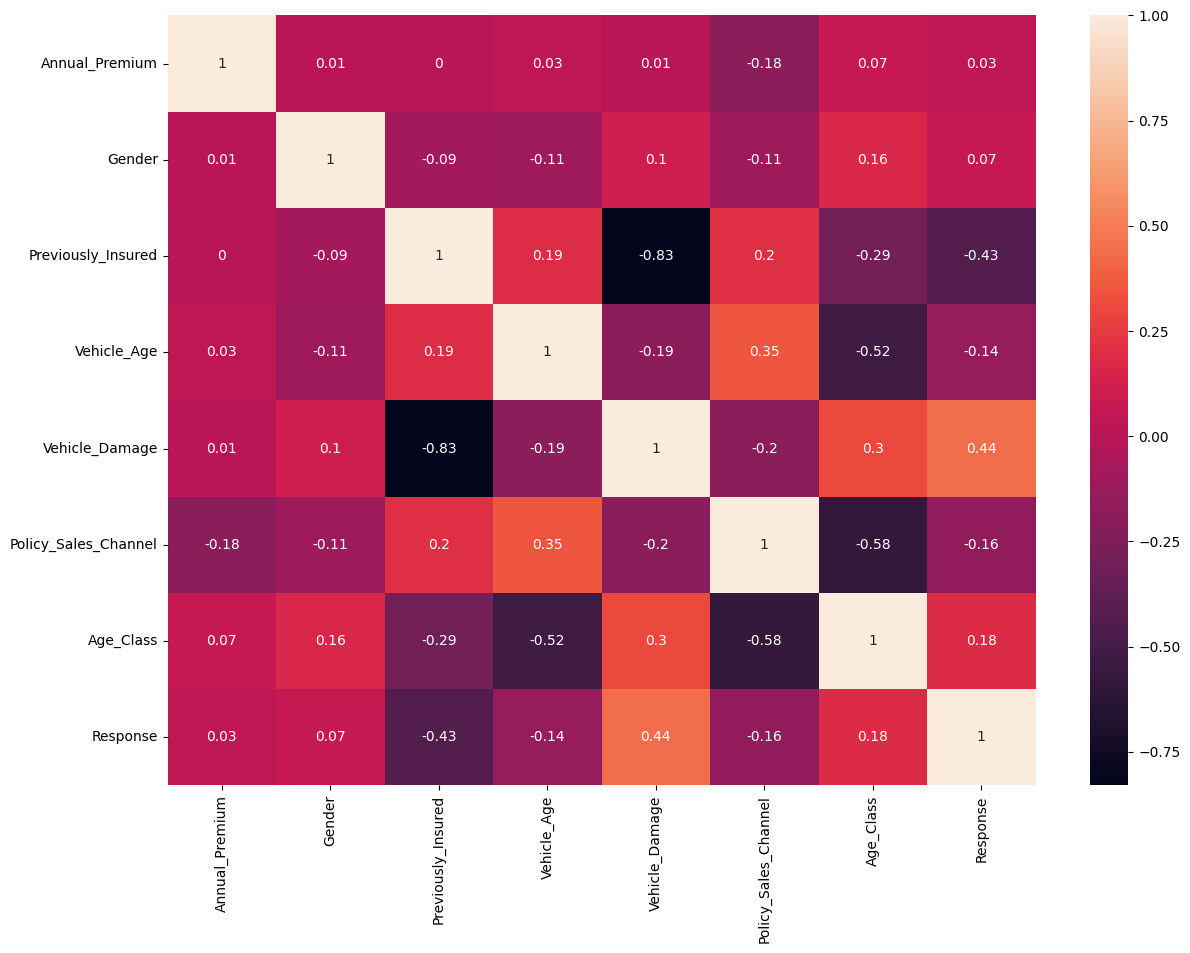

In [320]:
#df_numerical = df_to_handle[["Age", "Vintage"]].copy()
df_numerical = df_to_handle[["Annual_Premium"]].copy()


response = df_to_handle["Response"].copy()

df_to_handle = pd.concat([df_numerical, df_categorical], axis=1)
df_to_handle = pd.DataFrame(std_scaler.fit_transform(df_to_handle), columns=df_to_handle.columns)
df_to_handle = pd.concat([df_to_handle, response], axis=1)

plt.figure(figsize=(14, 10))
corr_matrix = df_to_handle.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

for column in df_categorical.columns:
    print(df_to_handle[column].value_counts())

In [321]:
df_to_train = df_to_handle.drop("Previously_Insured", axis=1)#[["Age_Class", "Previously_Insured", "Vehicle_Age" ,"Response"]]

ids = np.array([i for i in range(df_to_train.shape[0])])

print(ids)
df_to_train.reindex(ids)


X = df_to_train.drop("Response", axis=1).copy()
Y = df_to_train["Response"].copy()

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

m_training = X_training.shape[0]
m_test = X_test.shape[0]




[     0      1      2 ... 282524 282525 282526]


In [322]:
print(X_training)

        Annual_Premium    Gender  Vehicle_Age  Vehicle_Damage  \
264191        0.032603  0.912321     0.829248        0.910480   
67549         1.148129 -1.096105     0.829248       -1.098322   
191499       -0.277349 -1.096105     0.829248       -1.098322   
75648         0.099541  0.912321    -0.879041        0.910480   
161478        0.313768 -1.096105    -0.879041       -1.098322   
...                ...       ...          ...             ...   
119879        0.428511 -1.096105     0.829248       -1.098322   
259178       -0.317119 -1.096105     0.829248       -1.098322   
131932        1.250791  0.912321     0.829248        0.910480   
146867       -0.094222  0.912321    -0.879041        0.910480   
121958        1.138648 -1.096105     0.829248       -1.098322   

        Policy_Sales_Channel  Age_Class  
264191             -0.139060  -0.567620  
67549               0.584985  -1.276298  
191499              0.584985  -1.276298  
75648              -0.139060   1.558412  
161478   

In [323]:
log_reg = LogisticRegression(penalty='l1', C=0.001, solver="liblinear", class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True, threshold=0.6)

Accuracy: 0.650
Log-Loss: 0.512
Train Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.74    157175
           1       0.38      0.96      0.55     40593

    accuracy                           0.67    197768
   macro avg       0.68      0.78      0.64    197768
weighted avg       0.86      0.67      0.70    197768



In [324]:
evaluate_model(log_reg, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.6)

Accuracy: 0.648
Log-Loss: 0.515
Test Report:
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     67395
           1       0.38      0.96      0.54     17364

    accuracy                           0.67     84759
   macro avg       0.68      0.78      0.64     84759
weighted avg       0.86      0.67      0.70     84759



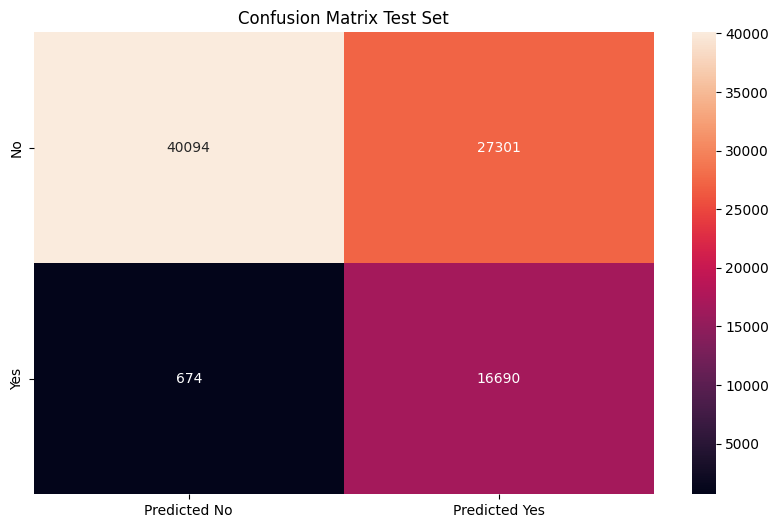

In [325]:
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.6, 1, 0)

confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

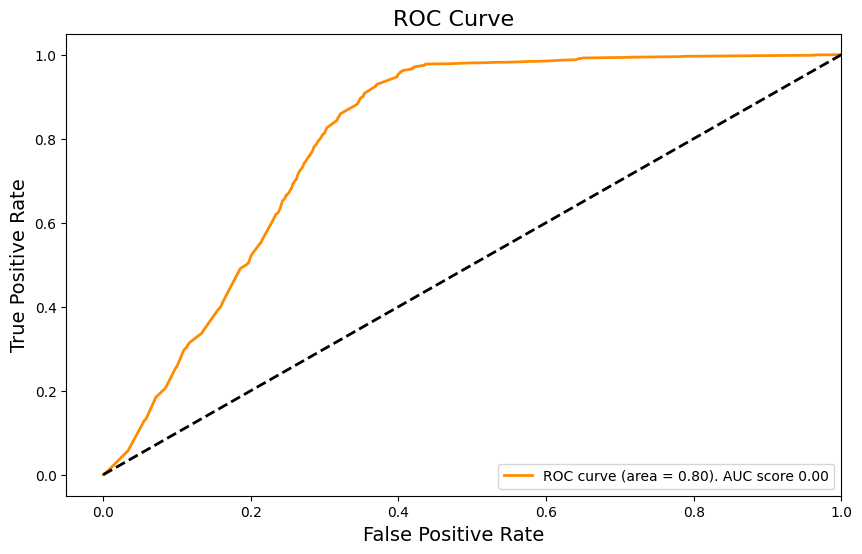

In [326]:
#plot roc curve
def plot_roc_curve(Y_test, y_pred_proba_test, multiclass=None,average=None):

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_score = 0
    if multiclass is not None and average is not None:
        auc_score = roc_auc_score(Y_test, y_pred_proba_test[:,1], multi_class=multiclass, average=average)
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f). AUC score %0.2f' % (roc_auc, auc_score))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, y_pred_proba_test)

Values of parameter C tried in 5-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 5-fold Cross-Validation: [0.32511833 0.32511833 0.32511833 0.32511833 0.32511833 0.32511833
 0.32511833 0.32511833 0.32511833 0.32511833]
Best value C according to 5-fold Cross-Validation: 0.0001
5-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.6528961140747858
Accuracy: 0.650
Log-Loss: 0.591
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.72    157175
           1       0.37      0.98      0.53     40593

    accuracy                           0.65    197768
   macro avg       0.68      0.77      0.63    197768
weighted avg       0.86      0.65      0.68    197768

Accuracy: 0.650
Log-Loss: 0.591
Train Report:
              precisi

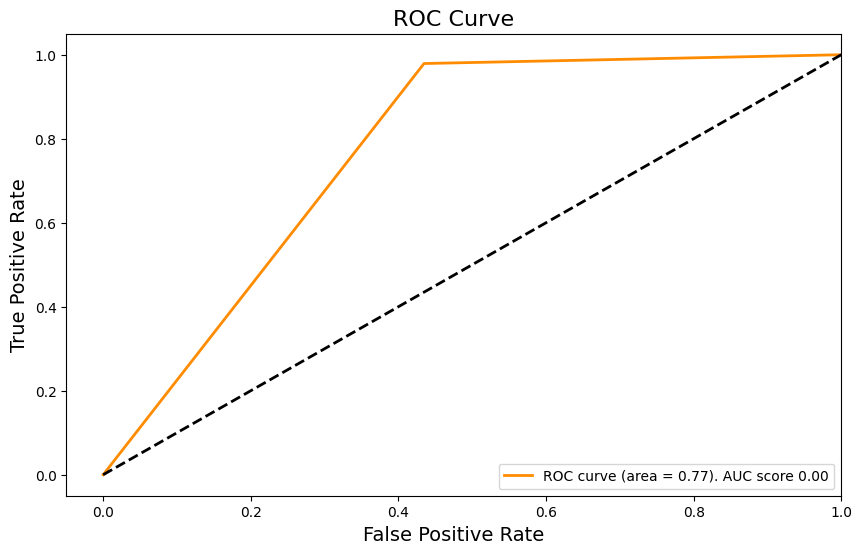

In [327]:
from sklearn.preprocessing import PolynomialFeatures
for i in range (1, 2):
    poly = PolynomialFeatures(i)
    X_training_poly = poly.fit_transform(X_training)
    regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')
    evaluate_model(regL2_full, (X_training_poly, Y_training), train_test_dataset='Train', print_report=True, threshold=0.6)
    y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
    plot_roc_curve(Y_training, y_pred_proba_training)
#poly = PolynomialFeatures(2)
#X_training_poly = poly.fit_transform(X_training)
#regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')

In [328]:
X_test_poly = poly.fit_transform(X_test)
evaluate_model(regL2_full, (X_test_poly, Y_test), train_test_dataset='Test', print_report=True, threshold=0.6)


Accuracy: 0.648
Log-Loss: 0.593
Test Report:


              precision    recall  f1-score   support

           0       0.99      0.56      0.72     67395
           1       0.37      0.98      0.53     17364

    accuracy                           0.65     84759
   macro avg       0.68      0.77      0.63     84759
weighted avg       0.86      0.65      0.68     84759



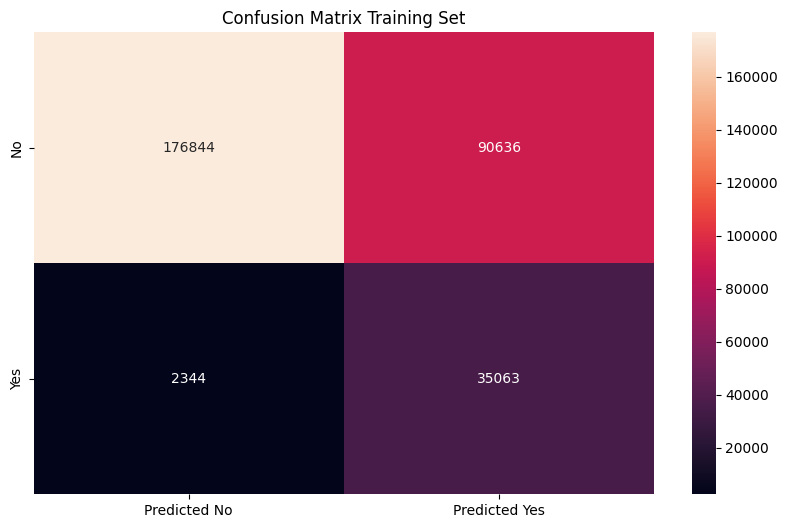

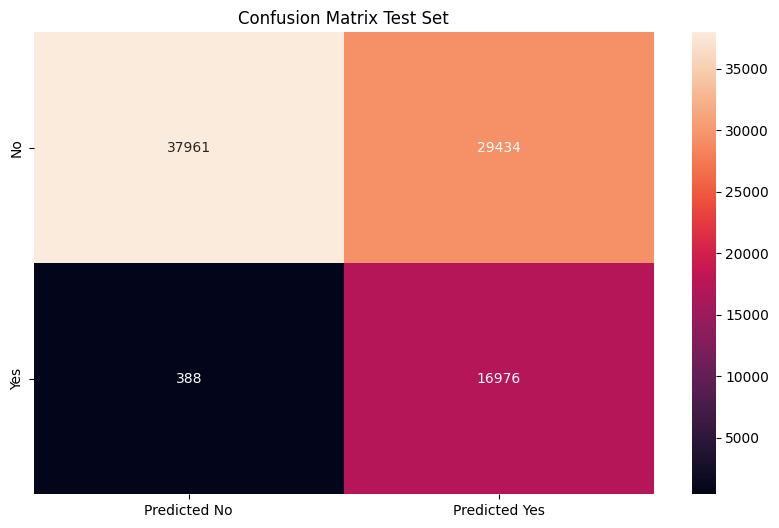

In [329]:
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
y_pred_training = np.where(y_pred_proba_training[:,1] > 0.6, 1, 0)
confusion_matrix_training = confusion_matrix(Y_training, y_pred_training)

y_pred_proba_test = regL2_full.predict_proba(X_test_poly)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.6, 1, 0)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

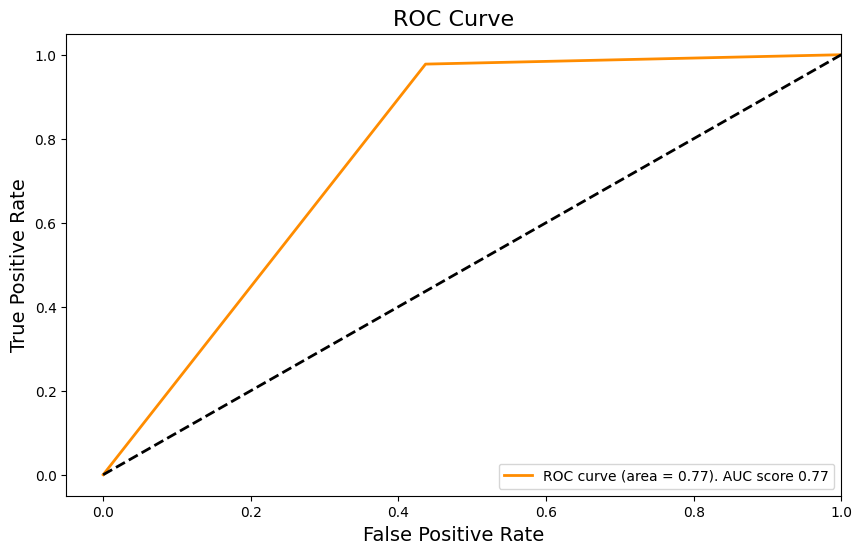

In [330]:
plot_roc_curve(Y_test, y_pred_proba_test, multiclass='ovo', average='macro')
